## GENERATING THE DDBB OF PICTURES TO TRAIN THE MODEL




1. choosing the brush stroke:
    - from the brush stroke data base, randomly select a bs shape, (./data/brush_strokes/00_bs_db/) (1 to n bs's at time)
    - apply transformations (size, rotation degrees,..) 
    - select a color from the generated palette  
    

2. painting:
    - include the bs in the frame,
    - random location, 
    - retain the new variable "deepness"
    
    
    
___


In [1]:
import numpy as np
import cv2


import random
import matplotlib.pyplot as plt

%matplotlib inline

import os

from PIL import Image

import pandas as pd



In [2]:
#from google.colab import files
 
#files.upload()  

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir_path = '/content/drive/MyDrive/TFM/00_bs_db/'
paint_path='/content/drive/MyDrive/TFM/02_paintings/'
paint_path_out='/content/drive/MyDrive/TFM/03_paintings_out/'

#paint_path_in_test='/content/drive/MyDrive/TFM/05_test/05_test/IN/'
#paint_path_out_test='/content/drive/MyDrive/TFM/05_test/05_test/OUT/'
#path_model='/content/drive/MyDrive/TFM/04_models/'


In [4]:
#https://github.com/matteo-ronchetti/Pointillism/commit/cb6d4454b636488fc2a1993b93f338a2341ba459
# function that randomly select the coordenates for the brush strokes

def randomized_grid(h, w, scale):
    if ( scale==0):
        scale=min(h,w)//3
    assert (scale > 0)

    r = scale//2

    #flg_exit=0 #limitado a 2 puntos

    grid = []
    for i in range(0, h, scale):
        for j in range(0, w, scale):
            y = random.randint(-r, r) + i
            x = random.randint(-r, r) + j

            #if flg_exit >= 2: 
            #    break #limitado a 2 puntos
            #flg_exit+=1 #limitado a 2 puntos  
             
            grid.append((y % h, x % w))        
             
          
    random.shuffle(grid)
    return grid
    
#type(grid)
#len(grid)
#type(grid[0])
def plot_grid(grid,h,w):
    x_val = [x[0] for x in grid]
    y_val = [x[1] for x in grid]
    
    plt.axis([0, h,0, w])    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.scatter(x_val,y_val)
    plt.show()




##  Palette of colours

references

first try https://codeboje.de/fun-colors-or-making-art-python/

Palette from picture https://kylermintah.medium.com/coding-a-color-palette-generator-in-python-inspired-by-procreate-5x-b10df37834ae

Apply colours to bs https://stackoverflow.com/questions/28999287/generate-random-colors-rgb

https://stackoverflow.com/questions/51728957/create-a-color-palette-image-from-a-list-of-rgb-color


___

In [5]:
#https://gist.github.com/adewes/5884820

def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

def generate_palette(n_colors,pastel_factor=0.5):
    palette_color = []

    for i in range(0,n_colors):
        palette_color.append(generate_new_color(palette_color,pastel_factor = pastel_factor))
       # print(palette_color)
    return palette_color  

   

### Creating the paintings

Generating the elements for the painting:

- selection of frame size from a limited list
- random of the number of bs to paint and the coordenates in the above frame
- random of the bs from the bs database (shape)
- random angle to apply to the above bs
- random pct of resize to apply to the bs
- random palette of colours to apply (n = number of bs to paint)

Painting:

- With the above elements, create a paint. 
- Save the paint

Output:
- List of frames(n), each with an individual bs from the saved paint



In [6]:
#db of  brush strokes images in list

def load_lst_of_bs():

    # list to store files
    lst_bs = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            lst_bs.append(path)
    #print(lst_bs, len(lst_bs))
    return lst_bs

In [7]:
# lst of arrays to df into csv

def paint_df(lst_imag, paint_id):
    
    #all_bs=[item for item in range(len(lst_imag))]
    #print('n_bs:',all_bs)
    for k in range(len(lst_imag)):
        
        imag_k_t= lst_imag[k]
        
        if k==0:               
            array_imag=np.where(imag_k_t==1,0,imag_k_t)            
        else:             
            array_imag=np.where(imag_k_t==1,array_imag,imag_k_t)
            #array_imag=np.where(array_imag > 1,imag_k_t,array_imag)              
           
            
    #df= pd.DataFrame.from_records(array_imag) 
    
    #pesa mas este formato que el comentado anterior, pero es mas intuitivo para después incluir depth

    data_to_df = []
    for i in range(array_imag.shape[1]):
        for j in range(array_imag.shape[0]):
            data_to_df.append({'x': j, 'y': i, 'r':array_imag[j, i,0],
                               'g':array_imag[j, i,1],'b':array_imag[j, i,2] })

    

    #df = pd.DataFrame(data_to_df)
    #df.to_csv(paint_path + paint_id + '.csv', index=False)  #, index=False
    
    array_imag=np.where(array_imag == 0,1,array_imag)  
    
    return array_imag

In [13]:


#scale_points=75 # the higher, less number of brush strokes in the frame


def paint_generator (paint_idx,scale_points):   
    
#random parameters

    #lst_frame_sizes=[(600,600),(400,600),(600,400),(800,400),(400,800),(600,200), (200,600),(200,200),(400,400)]
    lst_frame_sizes=[(128,128)]

    #______________frame selection from the list
    frame_size=random.choice(lst_frame_sizes)

    #print("Randomly selected frame size:",frame_size)

    bs_centers = randomized_grid(h=frame_size[0], w=frame_size[1],scale=scale_points) # valorar introducir la scale en un random limitado

    plot_grid (grid=bs_centers,h=frame_size[0],w=frame_size[1])

    #print('Num de brush strokes {}. Donde las coordenadas de los centroides{}:'.format(len(bs_centers),bs_centers))
    lst_bs=load_lst_of_bs()

    #______________elegir aleatoriamente n=len(bs_centers) centroides donde se van a situar los bs, selección de bs
    bs_select=random.sample(lst_bs, len(bs_centers))
    #print("brush strokes seleccionados de la db de bs:", bs_select)

    #______________ seleccionar un angulo para girar la figura [0,360]
    lst_degrees=[x for x in range(360)]
    degree=random.sample(lst_degrees, len(bs_centers))
    #print("grados de giro para los bs:", degree)

    #______________añadir un cambio en el tamaño del bs en base a un %. Rango elegido :de -30 a 30
    lst_pct=[(x) for x in range(100,250)]
    lst_scale_percent=random.sample(lst_pct, len(bs_centers))
    #print("escala de tamaño a aplicar en %:", lst_scale_percent)

    #______________colors
    palette = generate_palette(len(bs_centers),pastel_factor=0.5)
    palette_array = np.array(palette)[np.newaxis, :, :]
    plt.imshow(palette_array)
    
    plt.axis('off')    
    plt.show()
    lst_colors=palette_array.tolist()
    #print('Array con los rgb de la paleta seleccionada {}.'.format(lst_colors))
    
    
#painting

    #generating the frame from frame_size
    blank_image = np.zeros((frame_size[0],frame_size[1],3), np.uint8)
    #adding bs's en bs_centers, en el color de la paleta
    #[0]
    lst_imag=[]
    for k in range (len(bs_centers)):

        bs=bs_select[k]
        bs_xy=bs_centers[k]
        bs_color=lst_colors[0][k]
        bs_scale=lst_scale_percent[k]
        bs_angle=degree[k]

        #print ("\n figura bs:",bs,"\n coord:",bs_xy,"\n color:",bs_color,'\n scale:',bs_scale,"\n angle:",bs_angle )
        #blank_image[bs_xy[0],bs_xy[1]]=bs_color

        #rotation
        bs_k_im=Image.open(dir_path + bs)
        rotated=bs_k_im.rotate(bs_angle, expand=True)
        bs_k = np.asarray(rotated)

        #resize
        width = int(bs_k.shape[1] * (1 + bs_scale / 100))
        height = int(bs_k.shape[0] * (1 +  bs_scale / 100))
        #print(bs_k.shape[0],bs_k.shape[1])
        bs_k = cv2.resize(bs_k, (width, height))


        #centramos el bs en el punto donde tenemos que colocarlo
        bs_center=(int(bs_k.shape[0] /2) , int(bs_k.shape[1] /2))
        adjust=(bs_xy[0]-bs_center[0],bs_xy[1]-bs_center[1])

        rgb_tresh=200
        (x,y) = np.where((bs_k[:,:, 0] > rgb_tresh) & (bs_k[ :,:, 1] > rgb_tresh) & (bs_k[:, :, 2] >  rgb_tresh))
        (x,y) = (x + adjust[0], y + adjust[1] )
        
            
        #generamos un array de imagenes donde layer=index_array =orden_de_pintura =k 
        imag_k = np.ones((frame_size[0],frame_size[1],3),np.float64)  

        x2= x[(y< frame_size[1]) & (x <frame_size[0]) & (x>0) & (y>0)]
        y2= y[(y< frame_size[1]) & (x <frame_size[0]) & (x>0) & (y>0) ]
        x=x2
        y=y2
        imag_k[x,y] = lst_colors[0][k]

        lst_imag.append(imag_k)
        #print(imag_k.shape, lst_colors[0][k])
        #print the image kept in list, first we need to transpose
        #imag_k_t= imag_k.transpose(1, 0, 2)
        #print(imag_k_t.shape)
        #plt.axis([0, frame_size[0],0, frame_size[1]])
        #plt.imshow(imag_k_t)     
        

        #implot = plt.imshow(blank_image)

        #plt.axis('equal')
        #plt.xlim(0, frame_size[0]) 
        #plt.ylim(0, frame_size[1])
        #plt.scatter(x,y,color=lst_colors[0][k])
        plt.scatter(x,y,color=[lst_colors[0][k]],s=1, alpha=1)
        #print the image kept in list   
 
        #plt.show()
        #bs_k_im
        
     
    plt.axis([0, frame_size[0],0, frame_size[1]])
    #print('frame_size_saved:',frame_size[0],frame_size[1])
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.gca().get_yaxis().set_visible(False)
    #plt.gca().get_xaxis().set_visible(False)
    
    #plt.gca().set_axis_off()
    #plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
     
        
    #para guardar, eliminamos los ejes
    
    #plt.axis('off')
    paint_id="paint_" + ("0"*4 + str(paint_idx))[-5:] 
#plt.savefig(paint_path + paint_id + ".png")
    #bbox_inches='tight'
    #pad_inches=0.0
    
    #para mostrar, dejamos los axis
    #plt.axis('off')  
    
    plt.show()   
    
    array_imag=paint_df(lst_imag,paint_id)
    
  
    Image.fromarray((array_imag * 255).astype('uint8'),'RGB').save(paint_path + paint_id + ".png")  
    
    
    #plt.xlim(0, frame_size[0]) 
    #plt.ylim(0, frame_size[1])
    return lst_imag, paint_id    
    
    

Show each brush stroke in a layer
lst_imag=lst_imag_2

print("number of brush strokes:{0}".format(len(lst_imag)))
for k in range(len(lst_imag)):
    imag_k_t= lst_imag[k].transpose(1, 0, 2)
    #print(imag_k_t.shape)
    
    plt.axis([0, lst_imag[k].shape[0],0, lst_imag[k].shape[1]])
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    
    plt.imshow(imag_k_t)
    plt.show()



## OVERLAPING 


notes
* https://stackoverflow.com/questions/60399182/testing-if-two-sprite-overlap-while-using-matrices
* https://gis.stackexchange.com/questions/60017/how-to-computational-efficiently-check-if-there-are-any-overlapping-polygons-in


# Output deepness

Keep from layer 0 to n-1, len(lst_imag_deep_3[0]) for each bs, the max between the previous layer and the former layer.

In the last layer, if the number asociated to a bs has desapearod, the bs is delated.


In [9]:
# delete bs that are covered completely by others. Desapear in the final picture.

# in the lst of bs's, from first to last, check whether the next layer is covering the previous one,  
# .- label each bs with its id number 1,2,3. Compare each bs with the previous.If there is overlap 
# keep the maximum value (ej max(1,3)-->3) 
# .- after de final bs has been checked, we will have all numbers (of bs) that are visible in the final picture,
# .- any number from 1 to nbs that is not in the final picture, will be deleted from the list.

def clean_invisible_bs(lst_imag):
    #print('n_bs:',len(lst_imag))
    all_bs=[item for item in range(len(lst_imag))]
    #print('n_bs:',all_bs)
    for k in range(len(lst_imag)):
        
        imag_k_t= lst_imag[k]
        
        if k==0:               
            imag_acum=np.where(imag_k_t==1,0,k+1)  # label the bs with k (from 1 to n bs's)           
        else:             
            imag_acum=imag_acum + np.where(imag_k_t==1,0,k+1) 
            imag_acum=np.where(imag_acum > k+1,k+1,imag_acum)  
        
        
        #diferent numbers found in imag_acum after last iteration of K
        distinct_bs=np.unique(imag_acum)
        delete_bs=[item for item in all_bs if item not in distinct_bs]
        delete_bs.sort(reverse=True)
        #print(f'bs:',k+1,distinct_bs)        
        
    return delete_bs

In [10]:
#find layers to assing by checking overlaping
#solution:overlaping recognition when:   
#sum(M1[ones to zeros]+M2[ones to zeros] transformed zeros to ones) <> product(M1[ones]+M2[ones])
def register_deepness(lst_imag):
    
    #drop invisible bs's
    #print('before_clean:',len(lst_imag))
    lst_delete =clean_invisible_bs(lst_imag)
    for k in lst_delete:        
        lst_imag.pop(k)
    #print('after_clean:',len(lst_imag))
    

    lst_imag_deep=[]
    for k in range(len(lst_imag)):
        imag_k_t= lst_imag[k]
        #print('image',k)

        layer_found=0    

        if k==0:               
            lst_imag_deep.append(imag_k_t) 
            layer_found=1
            #print('layer 0',len(lst_imag_deep)-1)
        else:
            max_layer_id=max(len(lst_imag_deep),0)
            for k_i in range(max_layer_id, 0 , -1):
                #print('k_i=',k_i)
                imag_cmp=lst_imag_deep[k_i-1]

                #comparación la sum(M1[ones to zeros]+M2[ones to zeros]  zero to ones) <> product(M1+M2 ones)
                sum_acumM_newM0=np.where(imag_cmp==1,0,imag_cmp) + np.where(imag_k_t==1,0,imag_k_t)
                sum_acumM_newM= np.where(sum_acumM_newM0==0,1,sum_acumM_newM0)            
                product_acumM_newM=np.multiply(imag_cmp,imag_k_t)

                if (sum_acumM_newM==product_acumM_newM).all(): #no overlaping, if not in layer 0 then go to next layer
                    if k_i-1 ==0:
                        lst_imag_deep[k_i-1]= sum_acumM_newM #in first layer,include the item in this layer
                        layer_found=1
                        #print('layer k_i',k_i-1)
                        break
                    else:
                        pass                
                else: #overlaping
                    if k_i ==len(lst_imag_deep): #last layer, add a new one
                        lst_imag_deep.append(imag_k_t) 
                        layer_found=1
                        #print('layer last1',len(lst_imag_deep)-1)
                        break
                    else:#include the item in the layer +1                    
                        layer_1=np.multiply(lst_imag_deep[k_i + 1 - 1 ],imag_k_t)
                        lst_imag_deep[k_i + 1 - 1 ]= layer_1 #change layer for a new one with the new element 
                        layer_found=1
                        #print('layer k_i+1 -1 ',k_i+1 -1 )
                        break
                    pass   

        if layer_found==0: # not clasified yet, add new layer
            lst_imag_deep.append(imag_k_t) 
            #print('layer last2',len(lst_imag_deep)-1)
        else:
            pass
        
    print('layers:',len( lst_imag_deep))
    
    

    return lst_imag_deep

# TRAINING DATA

Create the training / validation data

* first try: pictures with few strokes
* next steps: increase the num of strokes


The data can be handled as:
* image: a numpy array (x,y,[rgb]) and an array with the deepness
* dataset: columns x,y,r,g,b,stroke_id, deepness


____

curiosity: extraction of the skeleton of a stroke
https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html

curiosity:https://github.com/Huage001/PaintTransformer


In [11]:
# generating the output. matrix (x,y,n), where n=number of layer

def out_layers(lst_imag_deep, paint_id):
    
    for k in range(len(lst_imag_deep)):

            imag_k= lst_imag_deep[k]

            if k==0:               
                bs_depth=np.where(imag_k==1,0,k+1)  # label each bs with a number :k (from 1 to n bs's)           
            else:
                bs_depth=bs_depth + np.where(imag_k==1,0,k+1) 
                bs_depth=np.where(bs_depth > k+1,k+1,bs_depth)          

            #diferent numbers found in imag_acum after last iteration of K
            distinct_bs=np.unique(bs_depth)  
            np.savetxt(paint_path_out +  paint_id +'.csv', bs_depth[:, :, 0].astype('uint8'), delimiter=',')
            
   
 
    #bs_depth 
    print('distinct layers_id for bs in same layer:',distinct_bs)

    #___________________________________________________________________________

    depth_t=[]
    
    for i in range(bs_depth.shape[1]):
        for j in range(bs_depth.shape[0]):
            depth_t.append([j,i,bs_depth[j,i,0]])
    print('output shape: (x,y,nlayer):', bs_depth.shape) 
    #print(len(depth_t)   )   
    
    
    #depth_t = []
    #for i in range(bs_depth.shape[1]):
    #    for j in range(bs_depth.shape[0]):
    #        depth_t.append({'x': j, 'y': i, 'number': bs_depth[i, j,0]})

    #depth_t_df = pd.DataFrame(depth_t)        
    #___________________________________________________________________________

    #graph of layers

    depth_t_df=pd.DataFrame(depth_t, columns=['x','y','number'])
    #depth_t_df

    groups = depth_t_df.groupby('number')

    plt.axis([0, bs_depth.shape[0],0, bs_depth.shape[1]])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)

    for name, group in groups:

        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

    plt.legend()    
    plt.show()
    
    #save output as input, image: no se puede guardar como imagen, transforma la etiqueta de depth
    #Image.fromarray((bs_depth*255 ).astype('uint8'),'RGB').save(paint_path_out + paint_id + ".png")

    return depth_t_df#depth_t

In [18]:
#generating knum paintings from 1 to knum

knum=100

for k in range (knum):
    print('iteration:',k )
    
    #painting generation
    exec(f'lst_imag_{k+1}, paint_id_{k+1} = paint_generator(k+1,scale_points=100)')    
   
    #layer assignment
    exec(f'lst_imag_deep_{k+1} = register_deepness(lst_imag_{k+1})')
    
    #output generation
    exec(f'out_layers_{k+1} = out_layers(lst_imag_deep_{k+1},paint_id_{k+1})')   
    
    
    
    #include output in csv of paint
    #exec(f'df_paint_{k+1}=pd.read_csv(paint_path + paint_id_{k+1}+ ".csv")') 
        
    #final df with paint info and depth
    #exec(f'df_paint=df_paint_{k+1}.merge(out_layers_{k+1}, on = ["x", "y"])')   
    #df_paint=df_paint.rename(columns={"number": "depth"})
    #exec(f'df_paint.to_csv(paint_path + paint_id_{k+1} + ".csv", index=False)')  
   

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#generating knum paintings for test

#paint_path='/content/drive/MyDrive/TFM/05_test_2bs/IN/'
#paint_path_out='/content/drive/MyDrive/TFM/05_test_2bs/OUT/'

paint_path='/content/drive/MyDrive/TFM/05_test/IN/'
paint_path_out='/content/drive/MyDrive/TFM/05_test/OUT/'



knum=300

for k in range (knum):
    print('iteration:',k )
    
    #painting generation
    exec(f'lst_imag_{k+1}, paint_id_{k+1} = paint_generator(k+1,scale_points=100)')    
   
    #layer assignment
    exec(f'lst_imag_deep_{k+1} = register_deepness(lst_imag_{k+1})')
    
    #output generation
    exec(f'out_layers_{k+1} = out_layers(lst_imag_deep_{k+1},paint_id_{k+1})')   




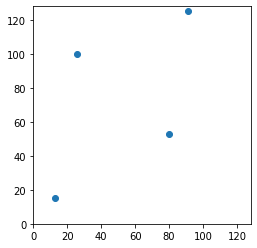

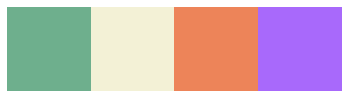

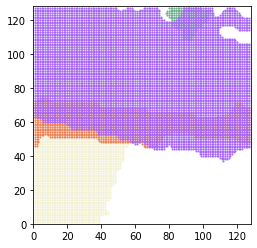

In [17]:
# testing paint generator
k=0
exec(f'paint_generator(k+1,scale_points=100)') 